In [133]:
import sys
from importlib import reload
sys.path.insert(0, "..")
import utils.misc as misc
import distributed
import distributed.sharded_matrix
reload(distributed.sharded_matrix)
from distributed.sharded_matrix import ShardedMatrix
from distributed import kernel
import numpy as np
import scipy.linalg
import pywren
reload(pywren)
import math
import itertools
import time
import cloudpickle
import importlib
import sys
from sklearn.datasets import fetch_mldata
from itertools import groupby
from operator import itemgetter
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn import metrics
import sys
import boto3
import concurrent.futures as fs
reload(boto3)
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [125]:
misc.rreload(kernel)

In [112]:
notebook_stdout = sys.stdout
notebook_stderr = sys.stderr
terminal_stdout = open('/dev/stdout', 'w')
terminal_stderr = open('/dev/stderr', 'w')

In [70]:
mnist = fetch_mldata('MNIST original', data_home="/tmp/mnist")
X_train = mnist.data[:60000].astype('float32')/255.0
y_train = mnist.target[:60000].astype('float32')
X_test = mnist.data[60000:].astype('float32')/255.0
y_test = mnist.target[60000:].astype('float32')


In [71]:
np.random.seed(0)
shuffled_idx = np.random.choice(X_train.shape[0], X_train.shape[0], replace=False)
X_train = X_train[shuffled_idx] 
y_train = y_train[shuffled_idx]
y_train_one_hot = np.eye(10)[y_train.astype('int')]


In [135]:
X_train_sharded.blocks

[((0, 4096), (0, 100)),
 ((0, 4096), (100, 200)),
 ((0, 4096), (200, 300)),
 ((0, 4096), (300, 400)),
 ((0, 4096), (400, 500)),
 ((0, 4096), (500, 600)),
 ((0, 4096), (600, 700)),
 ((0, 4096), (700, 784)),
 ((4096, 8192), (0, 100)),
 ((4096, 8192), (100, 200)),
 ((4096, 8192), (200, 300)),
 ((4096, 8192), (300, 400)),
 ((4096, 8192), (400, 500)),
 ((4096, 8192), (500, 600)),
 ((4096, 8192), (600, 700)),
 ((4096, 8192), (700, 784)),
 ((8192, 12288), (0, 100)),
 ((8192, 12288), (100, 200)),
 ((8192, 12288), (200, 300)),
 ((8192, 12288), (300, 400)),
 ((8192, 12288), (400, 500)),
 ((8192, 12288), (500, 600)),
 ((8192, 12288), (600, 700)),
 ((8192, 12288), (700, 784)),
 ((12288, 16384), (0, 100)),
 ((12288, 16384), (100, 200)),
 ((12288, 16384), (200, 300)),
 ((12288, 16384), (300, 400)),
 ((12288, 16384), (400, 500)),
 ((12288, 16384), (500, 600)),
 ((12288, 16384), (600, 700)),
 ((12288, 16384), (700, 784)),
 ((16384, 20480), (0, 100)),
 ((16384, 20480), (100, 200)),
 ((16384, 20480), (2

In [136]:
X_train_sharded.get_block(0,7)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

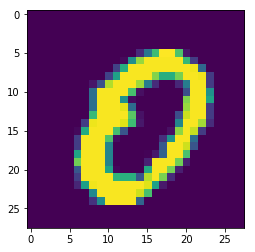

In [137]:
imshow(X_train_sharded[1024,:].reshape(28,28))

###### X_train_sharded

In [138]:
misc.rreload(pywren)
pwex = pywren.default_executor()

In [139]:
XtX = X_train.T.dot(X_train)

In [140]:
import distributed.matmul as matmul
reload(matmul)



<module 'distributed.matmul' from '../distributed/matmul.py'>

In [141]:
X_train_sharded.get_cache()

{}

In [142]:
import distributed.matmul as matmul

misc.rreload(pywren)
pwex = pywren.default_executor()

In [143]:
future = matmul.compute_XTX_pywren(pwex, X_train_sharded, axis=1, tasks_per_job=5)

Submitting job for chunk 0 in axis 1 for chunk 0 in axis 0
/home/ubuntu/anaconda3/lib/python3.6/site-packages/gspread
/home/ubuntu/anaconda3/lib/python3.6/site-packages/pylab.py
/home/ubuntu/anaconda3/lib/python3.6/site-packages/itsdangerous.py
/home/ubuntu/anaconda3/lib/python3.6/site-packages/cycler.py
/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyparsing.py
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipython_genutils
/home/ubuntu/anaconda3/lib/python3.6/site-packages/decorator.py
/home/ubuntu/anaconda3/lib/python3.6/site-packages/flask
/home/ubuntu/anaconda3/lib/python3.6/site-packages/terminado
/home/ubuntu/anaconda3/lib/python3.6/site-packages/wcwidth
/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyasn1_modules
/home/ubuntu/anaconda3/lib/python3.6/site-packages/simplegeneric.py
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ptyprocess
/home/ubuntu/anaconda3/lib/python3.6/site-packages/nose
/home/ubuntu/anaconda3/lib/python3.6/site-packages/babel
/home/ubuntu

In [146]:
XtX_pywren = future.download_matrix()

In [151]:
X_train_sharded._block_idxs(1)

[0, 1, 2, 3, 4, 5, 6, 7]

In [149]:
future

{}

In [150]:
np.all(np.isclose(XtX, future.download_matrix()))

True

In [65]:
future

In [64]:

reload(matmul)
matmul.compute_xtx_blockwise([(0,0)],future, X_train_sharded, other_block=1, axis=0)

(100, 4096)
True
XTX shape (100, 100)
0 0
0
4096
4096 4096


Exception: Incompatible block size: (100, 100) vs (4096, 4096)

In [161]:
X_train_sharded.get_block(1,0)
X_train_sharded.get_block(1,0)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [159]:
x_10 = block_kernel_solve(K_sharded, y_train_one_hot, max_iter=10, num_blocks=15, lambdav=1e-8)

NameError: name 'block_kernel_solve' is not defined

In [43]:
y_pred = np.argmax(K.dot(x_10), axis=1)

In [44]:
metrics.accuracy_score(y_pred, y_train)

0.98683333333333334

In [19]:
results = pwex.map(square, range(100))

In [20]:
futures = pywren.wait(results)

In [280]:
results[999].result() == 999**2

True

In [288]:
future = futures[0][0]

In [294]:
future.invoke_status

{'agg_data_in_s3': True,
 'aggregated_data_in_s3': False,
 'call_id': '00000',
 'callset_id': '7531a884-4663-42f8-aeab-9ba8e99e68db',
 'data_byte_range': (0, 4),
 'data_key': ('imagenet-raw',
  'pywren.jobs/7531a884-4663-42f8-aeab-9ba8e99e68db/aggdata.pickle'),
 'data_size_bytes': 5744,
 'data_upload_time': 0.05222177505493164,
 'data_upload_timestamp': 1492073257.0746202,
 'download_output_time': 0.6104545593261719,
 'download_output_timestamp': 1492073285.8397384,
 'func_key': ('imagenet-raw',
  'pywren.jobs/7531a884-4663-42f8-aeab-9ba8e99e68db/func.json'),
 'func_module_str_len': 475,
 'func_upload_time': 0.02534341812133789,
 'func_upload_timestamp': 1492073257.1000452,
 'host_submit_time': 1492073257.1557286,
 'job_invoke_timestamp': 1492073257.1138272,
 'job_max_runtime': 280,
 'lambda_function_name': 'pywren_1',
 'lambda_invoke_time': 0.6068289279937744,
 'lambda_invoke_timestamp': 1492073257.1557465,
 'output_key': ('imagenet-raw',
  'pywren.jobs/7531a884-4663-42f8-aeab-9ba8e99